In [ ]:
rcParams['figure.figsize'] = (16, 4) #wide graphs by default

# Sumarization techniques

## Pitch histogram and chromagram

Tzanetakis, G., Ermolinskyi, A., & Cook, P. (2003). Pitch histograms in audio and symbolic music information retrieval. Journal of New Music Research. Retrieved from http://www.tandfonline.com/doi/abs/10.1076/jnmr.32.2.143.16743

The accuracy and relevance of this measure depends on the pitch detection algorithm used.

The above article proposes using an enhanced version of the autocorrelation method that can eliminate octave-shift errors.

In [1]:
from essentia.standard import *

In [2]:
loader = MonoLoader(filename='sources/Bob Marley - Buffalo Soldier.mp3')
audio = loader()

In [12]:
def windowed_f0(input_sig, win_size, hop=None, sr=1.0, maxlags=None, fmax=4000.0):
    if not hop:
        hop = win_size/2
    if not maxlags:
        maxlags = win_size/4
        
    L = float(sr)/fmax
    window_start = arange(0, len(input_sig) - win_size, hop)
    acorrfs = []
    for start in window_start:
        w = input_sig[start: start+win_size]
        lags, acorr_inst, lines, line = acorr(w, maxlags=maxlags)
        acorrfs.append(acorr_inst)
        
    times = (window_start + win_size/2)/float(sr)
    apeaks = argmax(array(acorrfs)[:,:maxlags - round(L)], axis=1)
    f0 = float(sr)/(maxlags - apeaks)
    clf()
    return times, f0

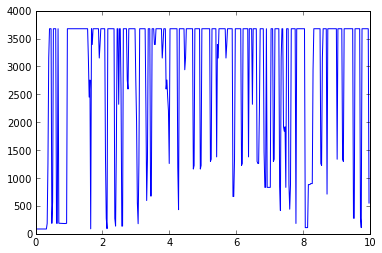

In [13]:
times, f0 = windowed_f0(audio[:441000], 2048, 1024, 44100, 512)
plot(times, f0)

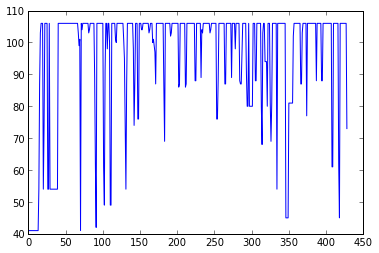

In [14]:
def midi2Hz(midinote, tuning=440.0):
    return tuning * (2**((midinote - 69)/12.0))

num_freqs = 8*12 # eight octaves from C0
quant_freqs = [midi2Hz(i + 24) for i in range(num_freqs)]

def quantize_freq(freq_list, quant_freqs, quant_offset=24):
    quantized = zeros_like(freq_list)
    for i in range(len(freq_list)):
        arg = argwhere(array(quant_freqs) > freq_list[i])
        if arg.size == 0 or arg[0] == 0:
            quantized[i] = 0
        elif quant_freqs[arg[0]] - freq_list[i] > freq_list[i] - quant_freqs[arg[0] - 1]:
            quantized[i] = arg[0] - 1
        else:
            quantized[i] = arg[0]
    return quantized + quant_offset

f0_q = quantize_freq(f0, quant_freqs)
plot(f0_q)

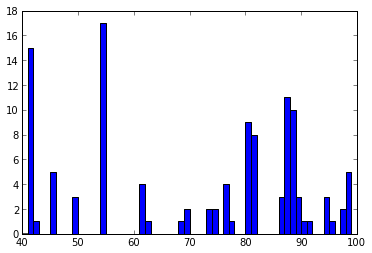

In [15]:
hist(f0_q, arange(40, 100));

In [16]:
pitches = []
pitchconfs = []

w = Windowing(type = 'hann')
spectrum = Spectrum()  # FFT() would return the complex FFT, here we just want the magnitude spectrum
pitchyin = PitchYinFFT()

for frame in FrameGenerator(audio, frameSize = 2048, hopSize = 1024):
    pitch, pconfidence = pitchyin(spectrum(w(frame)))
    pitches.append(pitch)
    pitchconfs.append(pconfidence)

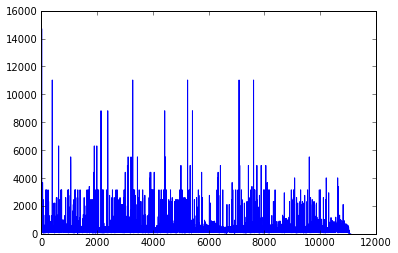

In [17]:
plot(pitches)

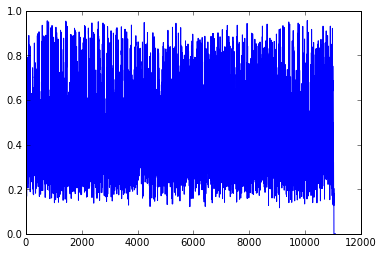

In [18]:
plot(pitchconfs)

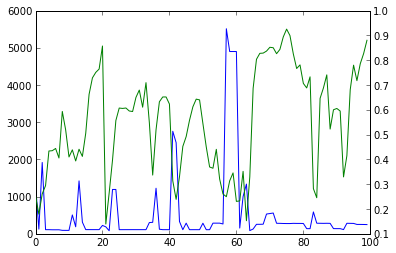

In [19]:
plot(pitches[1000:1100])
twinx()
plot(pitchconfs[1000:1100], 'g')

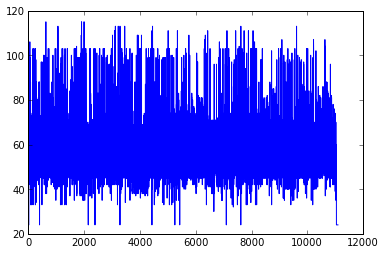

In [20]:
f0_q = quantize_freq(pitches, quant_freqs)
plot(f0_q)

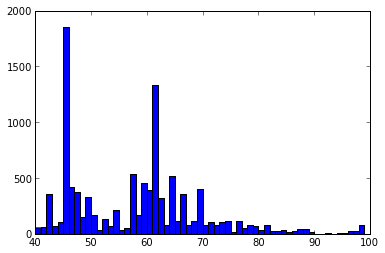

In [21]:
hist(f0_q, arange(40, 100));

In [22]:
loader = essentia.standard.MonoLoader(filename = 'sources/Stevie Wonder - Superstition.mp3')
audio = loader()

f0 = []
pitchconfs = []

for frame in FrameGenerator(audio, frameSize = 2048, hopSize = 1024):
    pitch, pconfidence = pitchyin(spectrum(w(frame)))
    f0.append(pitch)
    pitchconfs.append(pconfidence)

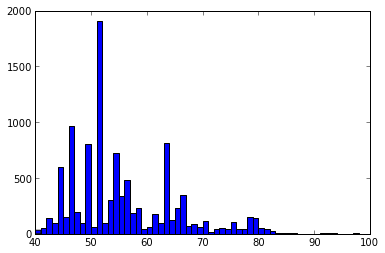

In [23]:
f0_q = quantize_freq(f0, quant_freqs)
n_wonder, bins, patches = hist(f0_q, arange(40, 101));

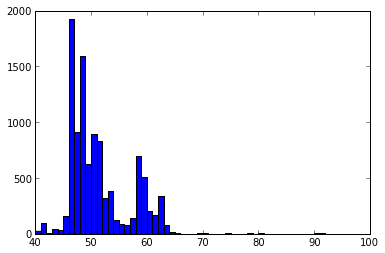

In [24]:
loader = essentia.standard.MonoLoader(filename = 'sources/Bob Dylan - Canadee-I-O.mp3')
dylan = loader()

f0 = []
pitchconfs = []

for frame in FrameGenerator(dylan, frameSize = 2048, hopSize = 1024):
    pitch, pconfidence = pitchyin(spectrum(w(frame)))
    f0.append(pitch)
    pitchconfs.append(pconfidence)

f0_q = quantize_freq(f0, quant_freqs)
n_dylan, bins, patches = hist(f0_q, arange(40, 101));

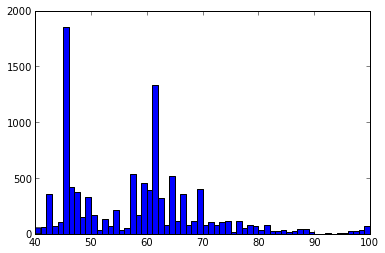

In [25]:
loader = essentia.standard.MonoLoader(filename = 'sources/Bob Marley - Buffalo Soldier.mp3')
marley = loader()

f0 = []
pitchconfs = []

for frame in FrameGenerator(marley, frameSize = 2048, hopSize = 1024):
    pitch, pconfidence = pitchyin(spectrum(w(frame)))
    f0.append(pitch)
    pitchconfs.append(pconfidence)

f0_q = quantize_freq(f0, quant_freqs)
n_marley, bins, patches = hist(f0_q, arange(40, 101));


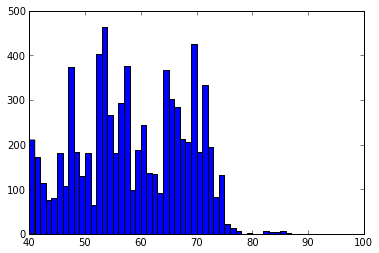

In [28]:
loader = essentia.standard.MonoLoader(filename = 'sources/Palestrina-Gloria.mp3')
palestrina = loader()

f0 = []
pitchconfs = []

for frame in FrameGenerator(palestrina, frameSize = 2048, hopSize = 1024):
    pitch, pconfidence = pitchyin(spectrum(w(frame)))
    f0.append(pitch)
    pitchconfs.append(pconfidence)

f0_q = quantize_freq(f0, quant_freqs)
n_palestrina, bins, patches = hist(f0_q, arange(40, 101));

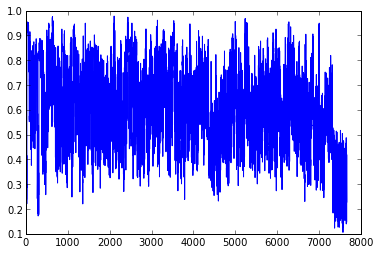

In [30]:
plot(pitchconfs)

### Folded pitch histogram

In [31]:
pclasses = n_wonder.reshape(5, 12).sum(axis=0)

<Container object of 12 artists>

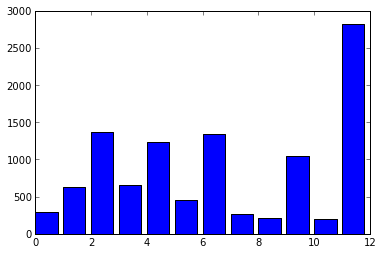

In [32]:
bar(arange(12), pclasses)

Folded pitch histograms are generally organized by fifths (C -> G -> D ... etc.)

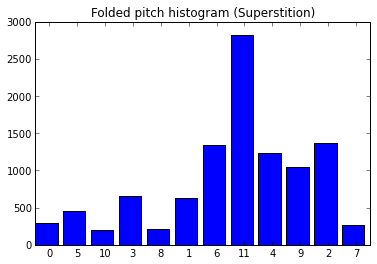

In [33]:
pclasses = n_wonder.reshape(5, 12).sum(axis=0)
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(pclasses[pc])
    pcs.append(pc)
    
bar(arange(12), foldedpcs)
xticks(arange(12) + 0.5, pcs);
title('Folded pitch histogram (Superstition)')
    

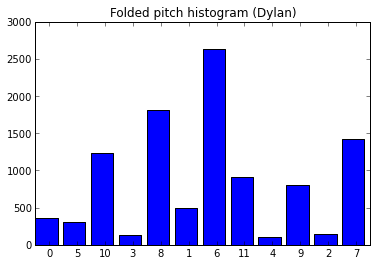

In [34]:
pclasses = n_dylan.reshape(5, 12).sum(axis=0)
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(pclasses[pc])
    pcs.append(pc)
    
bar(arange(12), foldedpcs)
xticks(arange(12) + 0.5, pcs);
title('Folded pitch histogram (Dylan)')


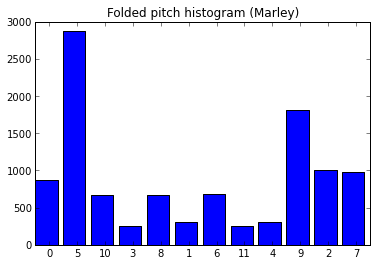

In [35]:
pclasses = n_marley.reshape(5, 12).sum(axis=0)
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(pclasses[pc])
    pcs.append(pc)
    
bar(arange(12), foldedpcs)
xticks(arange(12) + 0.5, pcs);
title('Folded pitch histogram (Marley)')

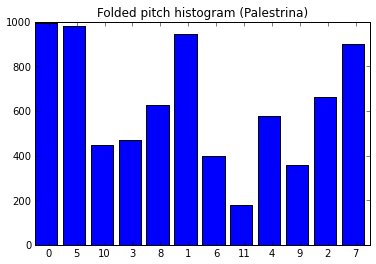

In [36]:
pclasses = n_palestrina.reshape(5, 12).sum(axis=0)
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(pclasses[pc])
    pcs.append(pc)
    
bar(arange(12), foldedpcs)
xticks(arange(12) + 0.5, pcs);
title('Folded pitch histogram (Palestrina)')

## Chromagram

Similar to the pitch histogram, but the notes are counted directly from the FFT bins.

https://github.com/bmcfee/librosa

In [37]:
loader = MonoLoader(filename='sources/Stevie Wonder - Superstition.mp3')
superstition = loader()

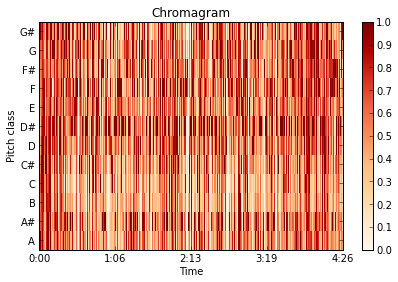

In [38]:
import librosa

cm = librosa.feature.chromagram(superstition, 44100, hop_length=1024)
librosa.display.specshow(cm, sr=44100, hop_length=1024, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

title('Chromagram')
colorbar()

tight_layout()

<Container object of 12 artists>

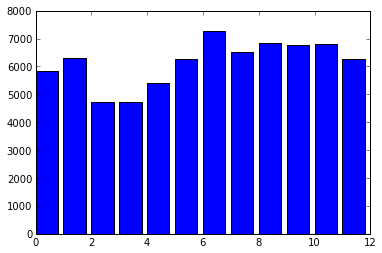

In [39]:
bar(arange(12), sum(cm, axis=1))

In [40]:
cm.shape

(12, 11457)

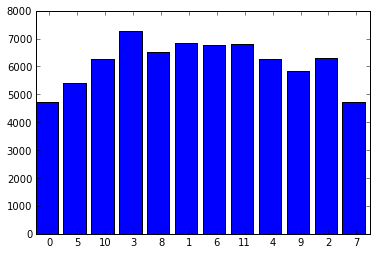

In [41]:
cm = sum(cm, axis=1)
cm = r_[cm[3:],cm[:3]]
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(cm[pc])
    pcs.append(pc)

bar(arange(12), cm)
xticks(arange(12) + 0.5, pcs);

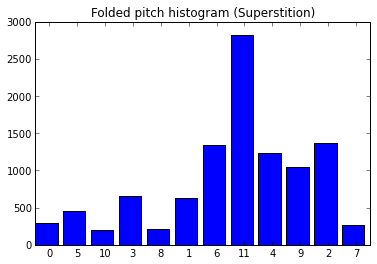

In [42]:
pclasses = n_wonder.reshape(5, 12).sum(axis=0)
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(pclasses[pc])
    pcs.append(pc)
bar(arange(12), foldedpcs)
xticks(arange(12) + 0.5, pcs);
title('Folded pitch histogram (Superstition)')

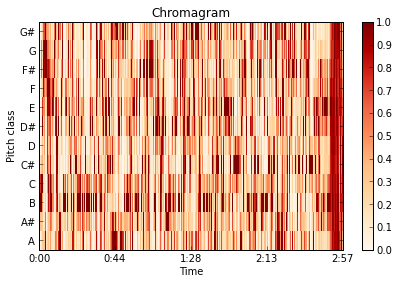

In [43]:
cm = librosa.feature.chromagram(palestrina, 44100, hop_length=1024)
librosa.display.specshow(cm, sr=44100, hop_length=1024, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

title('Chromagram')
colorbar()

tight_layout()

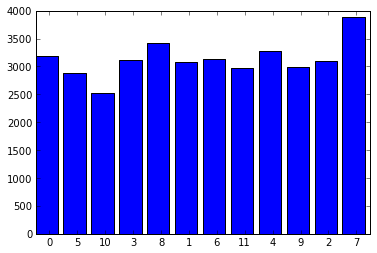

In [44]:
cm = sum(cm, axis=1)
cm = r_[cm[3:],cm[:3]]
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(cm[pc])
    pcs.append(pc)

bar(arange(12), cm)
xticks(arange(12) + 0.5, pcs);

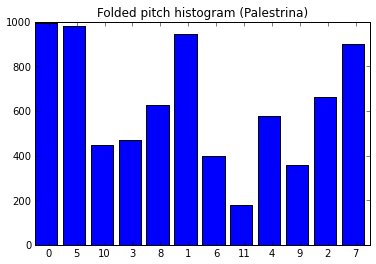

In [45]:
pclasses = n_palestrina.reshape(5, 12).sum(axis=0)
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(pclasses[pc])
    pcs.append(pc)
bar(arange(12), foldedpcs)
xticks(arange(12) + 0.5, pcs);
title('Folded pitch histogram (Palestrina)')

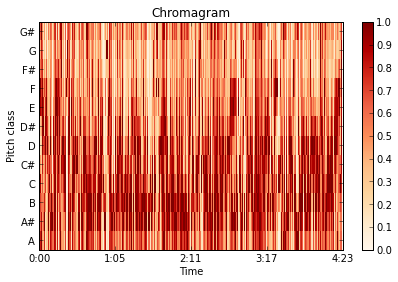

In [46]:
cm = librosa.feature.chromagram(dylan, 44100, hop_length=1024)
librosa.display.specshow(cm, sr=44100, hop_length=1024, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

title('Chromagram')
colorbar()

tight_layout()

<Container object of 12 artists>

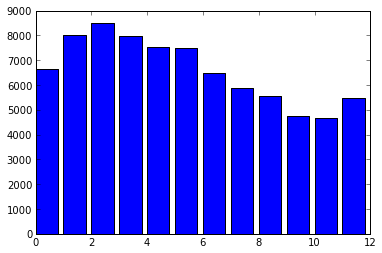

In [47]:
bar(arange(12), sum(cm, axis=1))

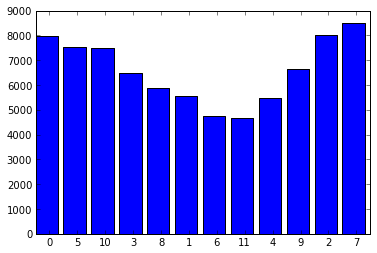

In [48]:
cm = sum(cm, axis=1)
cm = r_[cm[3:],cm[:3]]
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(cm[pc])
    pcs.append(pc)

bar(arange(12), cm)
xticks(arange(12) + 0.5, pcs);

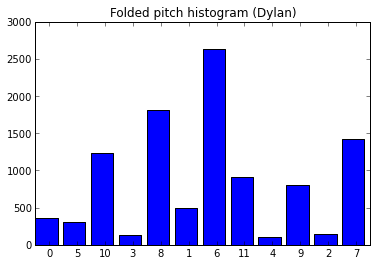

In [49]:
pclasses = n_dylan.reshape(5, 12).sum(axis=0)
foldedpcs = []
pcs = []
for i in range(12):
    pc = (i * 5)%12
    foldedpcs.append(pclasses[pc])
    pcs.append(pc)
bar(arange(12), foldedpcs)
xticks(arange(12) + 0.5, pcs);
title('Folded pitch histogram (Dylan)')

# Self-similarity matrix

http://en.wikipedia.org/wiki/Self-similarity_matrix

In [50]:
def windowed_rms(input_sig, win_size, hop=None, sr=1.0):
    if not hop:
        hop = winsize/2
    rms = []
    window_start = arange(0, len(input_sig) - win_size, hop)
    
    for start in window_start:
        w = input_sig[start: start+win_size].astype(float)
        rms_inst = sqrt(mean(w**2))
        rms.append(rms_inst)
    times = (window_start + win_size/2)/float(sr)
    return times, rms

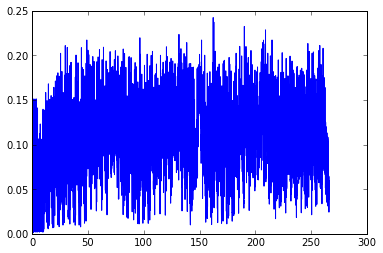

In [69]:
times, super_rms = windowed_rms(superstition, 4096, 512, 44100)
plot(times, super_rms)

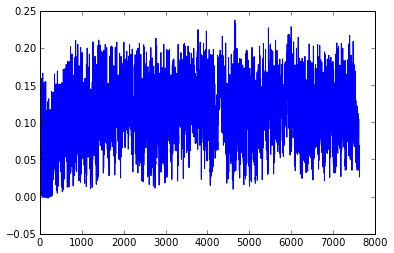

In [70]:
from scipy.signal import decimate

rms_dec = decimate(super_rms, 3)
plot(rms_dec)


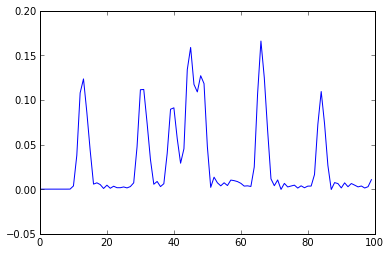

In [71]:
plot(rms_dec[:100])

In [72]:
ss_win_size = 200
ss_hop = 10

in_sig = rms_dec

win_start = arange(0, len(in_sig)- ss_win_size, ss_hop)

ssm = []

for starti in win_start:
    for startj in win_start:
        wini = in_sig[starti: starti+ss_win_size]
        winj = in_sig[startj: startj+ss_win_size]
        ssm.append(corrcoef(wini, winj)[0, 1])

ssm = array(ssm).reshape(len(win_start), len(win_start))

In [73]:
ssm.shape

(744, 744)

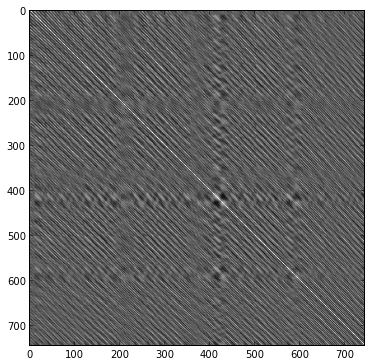

In [74]:
imshow(ssm, cmap='gray')

#xticks(linspace(0, 754, 8),linspace(0, times[-1], 8).astype(int))
#ylim((0, 44))
gcf().set_figheight(8)

In [58]:
ss_win_size = 200
ss_hop = 10

times, super_rms = windowed_rms(dylan, 4096, 512, 44100)
rms_dec = decimate(super_rms, 3)
in_sig = rms_dec

win_start = arange(0, len(in_sig)- ss_win_size, ss_hop)

ssm = []

for starti in win_start:
    for startj in win_start:
        wini = in_sig[starti: starti+ss_win_size]
        winj = in_sig[startj: startj+ss_win_size]
        ssm.append(corrcoef(wini, winj)[0, 1])

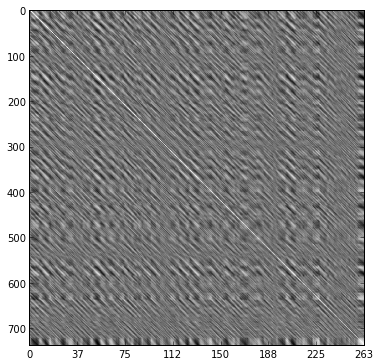

In [59]:
ssm = array(ssm).reshape(len(win_start), len(win_start))
imshow(ssm, cmap='gray')

#xticks(linspace(0, ssm.shape[0], 8),linspace(0, times[-1], 8).astype(int))
#ylim((0, 44))
gcf().set_figheight(8)

In [60]:
ss_win_size = 200
ss_hop = 10

times, super_rms = windowed_rms(palestrina, 4096, 512, 44100)
rms_dec = decimate(super_rms, 3)
in_sig = rms_dec

win_start = arange(0, len(in_sig)- ss_win_size, ss_hop)

ssm = []

for starti in win_start:
    for startj in win_start:
        wini = in_sig[starti: starti+ss_win_size]
        winj = in_sig[startj: startj+ss_win_size]
        ssm.append(corrcoef(wini, winj)[0, 1])

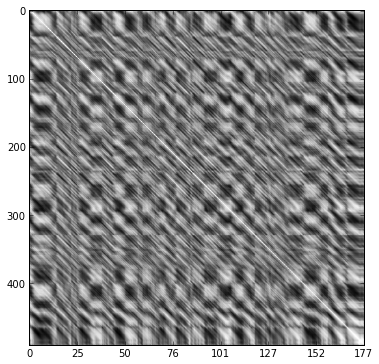

In [61]:
ssm = array(ssm).reshape(len(win_start), len(win_start))
imshow(ssm, cmap='gray')

xticks(linspace(0, ssm.shape[0], 8),linspace(0, times[-1], 8).astype(int))
#ylim((0, 44))
gcf().set_figheight(8)

## Self-similarity of MFCCs

Self-similarity matrices can be applied to any feature.

Foote, J. (1999). Visualizing music and audio using self-similarity. Proceedings of the Seventh ACM International Conference on Multimedia (Part 1) - MULTIMEDIA ’99, 77–80. doi:10.1145/319463.319472

In [75]:
loader = MonoLoader(filename = 'sources/Dire Straits - Walk of life.mp3')
dire = loader()

In [76]:
mfcc = MFCC()

help(MFCC)

Help on class Algo in module essentia.standard:

class Algo(Algorithm)
 |  MFCC
 |  
 |  
 |  Inputs:
 |  
 |    [vector_real] spectrum - the audio spectrum
 |  
 |  
 |  Outputs:
 |  
 |    [vector_real] bands - the energies in mel bands
 |    [vector_real] mfcc - the mel frequency cepstrum coefficients
 |  
 |  
 |  Parameters:
 |  
 |    highFrequencyBound:
 |      real ∈ (0,inf) (default = 11000)
 |      the upper bound of the frequency range [Hz]
 |  
 |    lowFrequencyBound:
 |      real ∈ [0,inf) (default = 0)
 |      the lower bound of the frequency range [Hz]
 |  
 |    numberBands:
 |      integer ∈ [1,inf) (default = 40)
 |      the number of mel-bands in the filter
 |  
 |    numberCoefficients:
 |      integer ∈ [1,inf) (default = 13)
 |      the number of output mel coefficients
 |  
 |    sampleRate:
 |      real ∈ (0,inf) (default = 44100)
 |      the sampling rate of the audio signal [Hz]
 |  
 |  
 |  Description:
 |  
 |    This algorithm computes the mel-frequency c

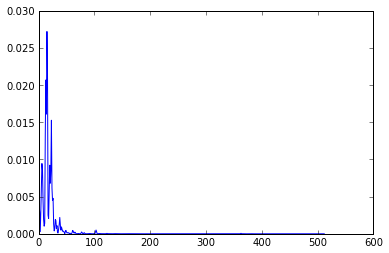

In [77]:
w = Windowing(type = 'hann')
spectrum = Spectrum()  # FFT() would return the complex FFT, here we just want the magnitude spectrum

frame = dire[5*44100 : 5*44100 + 1024]
spec = spectrum(w(frame))

plot(spec)

In [78]:
mfccs = []

for frame in FrameGenerator(dire, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w(frame)))
    mfccs.append(mfcc_coeffs)

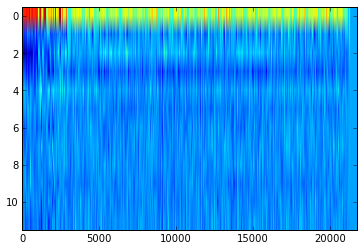

In [79]:
mfccs = array(mfccs).T
imshow(mfccs[1:,:], aspect='auto')

### Essentia Streaming mode

In [80]:
from essentia.streaming import *

# This will overwrite the previous "standard" mode imports!

Starts the same way:

In [81]:
loader = MonoLoader(filename = 'sources/Dire Straits - Walk of life.mp3')
frameCutter = FrameCutter(frameSize = 1024, hopSize = 512)
w = Windowing(type = 'hann')
spec = Spectrum()
mfcc = MFCC()

But then things are "connected" in a graph

In [82]:
loader.audio >> frameCutter.signal
frameCutter.frame >> w.frame >> spec.frame
spec.spectrum >> mfcc.spectrum

<essentia.streaming._StreamConnector instance at 0x1b8f9b00>

And then run:

In [83]:
essentia.run(loader)

RuntimeError: MFCC::bands is not connected to any sink...

Ooops! Must remember to connect outputs too!

In [84]:
pool = essentia.Pool()

mfcc.bands >> (pool, 'lowlevel.mfcc_bands')
mfcc.mfcc >> (pool, 'lowlevel.mfcc')

In [85]:
essentia.run(loader)

In [86]:
print 'Pool contains %d frames of MFCCs' % len(pool['lowlevel.mfcc'])

Pool contains 21752 frames of MFCCs


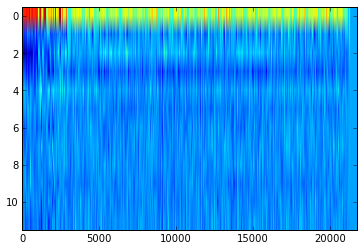

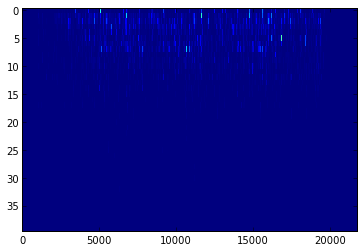

In [87]:
imshow(pool['lowlevel.mfcc'].T[1:,:], aspect = 'auto')
figure()
imshow(pool['lowlevel.mfcc_bands'].T, aspect = 'auto', interpolation = 'nearest')

Graphs can be reconfigured;

In [88]:
mfcc.mfcc.disconnect((pool, 'lowlevel.mfcc'))

fileout = FileOutput(filename = 'mfccframes.txt')

mfcc.mfcc >> fileout

# reset the network otherwise the loader in particular will not do anything useful
essentia.reset(loader)

# and rerun it!
essentia.run(loader)

In [91]:
mfcc_coefs = pool['lowlevel.mfcc'][:3000,1:]

mfcc_coefs.shape

(3000, 12)

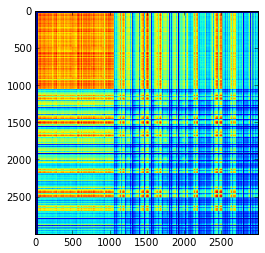

In [92]:
ssm = []

for mfcc_i in mfcc_coefs:
    for mfcc_j in mfcc_coefs:
        cc = sum(mfcc_i * mfcc_j)
        ssm.append(cc)

ssm = array(ssm).reshape(len(mfcc_coefs), len(mfcc_coefs))
imshow(ssm)

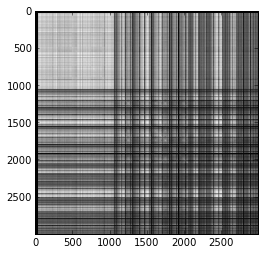

In [93]:
ssm = array(ssm).reshape(len(mfcc_coefs), len(mfcc_coefs))
imshow(ssm[:3000, :3000], cmap='gray', interpolation='nearest')

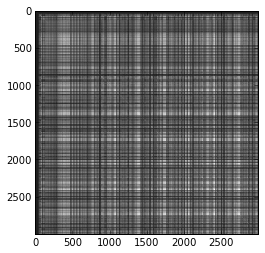

In [99]:
loader = MonoLoader(filename = 'sources/Bob Marley - Buffalo Soldier.mp3')
frameCutter = FrameCutter(frameSize = 1024, hopSize = 512)
w = Windowing(type = 'hann')
spec = Spectrum()
mfcc = MFCC()
pool = essentia.Pool()

loader.audio >> frameCutter.signal
frameCutter.frame >> w.frame >> spec.frame
spec.spectrum >> mfcc.spectrum
mfcc.bands >> (pool, 'lowlevel.mfcc_bands')
mfcc.mfcc >> (pool, 'lowlevel.mfcc')
essentia.run(loader)

mfcc_coefs = pool['lowlevel.mfcc'][:3000,1:]

ssm = []

for mfcc_i in mfcc_coefs:
    for mfcc_j in mfcc_coefs:
        cc = sum(mfcc_i * mfcc_j)
        ssm.append(cc)

ssm = array(ssm).reshape(len(mfcc_coefs), len(mfcc_coefs))
imshow(ssm[:3000, :3000], cmap='gray', interpolation='nearest')

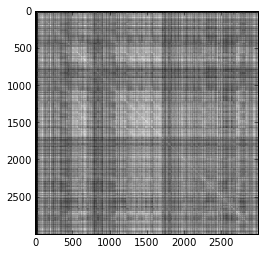

In [100]:
loader = MonoLoader(filename = 'sources/Messiaen-Turangalila4.mp3')
frameCutter = FrameCutter(frameSize = 1024, hopSize = 512)
w = Windowing(type = 'hann')
spec = Spectrum()
mfcc = MFCC()
pool = essentia.Pool()

loader.audio >> frameCutter.signal
frameCutter.frame >> w.frame >> spec.frame
spec.spectrum >> mfcc.spectrum
mfcc.bands >> (pool, 'lowlevel.mfcc_bands')
mfcc.mfcc >> (pool, 'lowlevel.mfcc')
essentia.run(loader)

mfcc_coefs = pool['lowlevel.mfcc'][:3000,1:]

ssm = []

for mfcc_i in mfcc_coefs:
    for mfcc_j in mfcc_coefs:
        cc = sum(mfcc_i * mfcc_j)
        ssm.append(cc)

ssm = array(ssm).reshape(len(mfcc_coefs), len(mfcc_coefs))
imshow(ssm[:3000, :3000], cmap='gray', interpolation='nearest')

# Temporal summarization and Texture Window

In [101]:
from essentia import *
from essentia.standard import *

In [102]:
filename = 'sources/Isaac Hayes - Out Of The Ghetto.mp3'
audio = MonoLoader(filename = filename)()

# create the pool and the necessary algorithms
pool = Pool()
w = Windowing()
spec = Spectrum()
centroid = Centroid()

# compute the centroid for all frames in our audio and add it to the pool
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    c = centroid(spec(w(frame))) * 44100/2
    pool.add('lowlevel.centroid', c)

aggrpool = PoolAggregator(defaultStats = [ 'mean', 'var' ])(pool)


In [103]:
aggrpool.descriptorNames()

['lowlevel.centroid.mean', 'lowlevel.centroid.var']

In [104]:
aggrpool['lowlevel.centroid.mean']

2627.591796875

In [105]:
aggrpool['lowlevel.centroid.var']

2143515.0

In [106]:
sqrt(_)

1464.0747931714418

### Texture Window

Proposed by Tzanetakis and Cook to model the time needed to identify higher level features (e.g. identify instruments or genres)

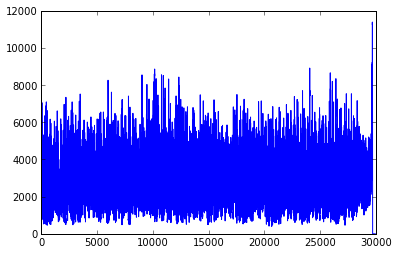

In [107]:
centroid = pool['lowlevel.centroid']
plot(centroid)

In [108]:
centroid.shape

(29938,)

In [109]:
tex_win_time = 1.0 #seconds
hopsize = 512
sr = 44100
tex_win_size = int(tex_win_time * sr/hopsize)
tex_win_size

86

In [110]:
win_start = arange(0, len(centroid), tex_win_size)
centroid_tex_mean = []
centroid_tex_var = []
for start in win_start:
    win = centroid[start: start + tex_win_size]
    centroid_tex_mean.append(mean(win))
    centroid_tex_var.append(var(win))
    

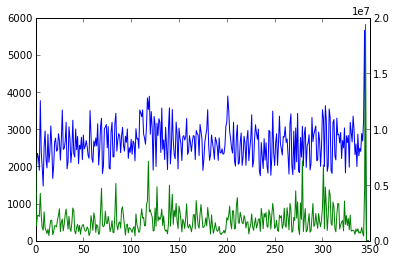

In [111]:
plot(centroid_tex_mean)
twinx()
plot(centroid_tex_var, 'g')

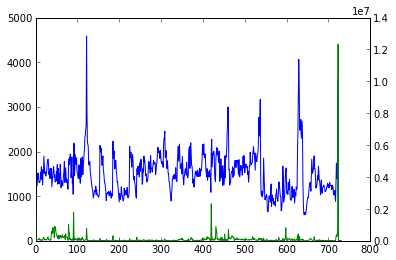

In [112]:
filename = 'sources/Messiaen-Turangalila4.mp3'
tex_win_time = 1.0 #seconds
hopsize = 512
sr = 44100
tex_win_size = int(tex_win_time * sr/hopsize)
tex_win_size


audio = MonoLoader(filename = filename, sampleRate=sr)()

# create the pool and the necessary algorithms
pool = Pool()
w = Windowing()
spec = Spectrum()
centroid = Centroid()

# compute the centroid for all frames in our audio and add it to the pool
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = hopsize):
    c = centroid(spec(w(frame))) * sr/2
    pool.add('lowlevel.centroid', c)

centroid = pool['lowlevel.centroid']
win_start = arange(0, len(centroid), tex_win_size)
centroid_tex_mean = []
centroid_tex_var = []
for start in win_start:
    win = centroid[start: start + tex_win_size]
    centroid_tex_mean.append(mean(win))
    centroid_tex_var.append(var(win))
    
plot(centroid_tex_mean)
twinx()
plot(centroid_tex_var, 'g')

## Beat histogram

"The first five peaks of the autocorrelation function are detected and their corresponding periodicities in beats per minute (bpm) are calculated and added in a “beat” histogram"

G. Tzanetakis and P. Cook. Musical genre classification of audio signals. IEEE Transactions on Speech and Audio Processing, 10(5):293–302, 2002

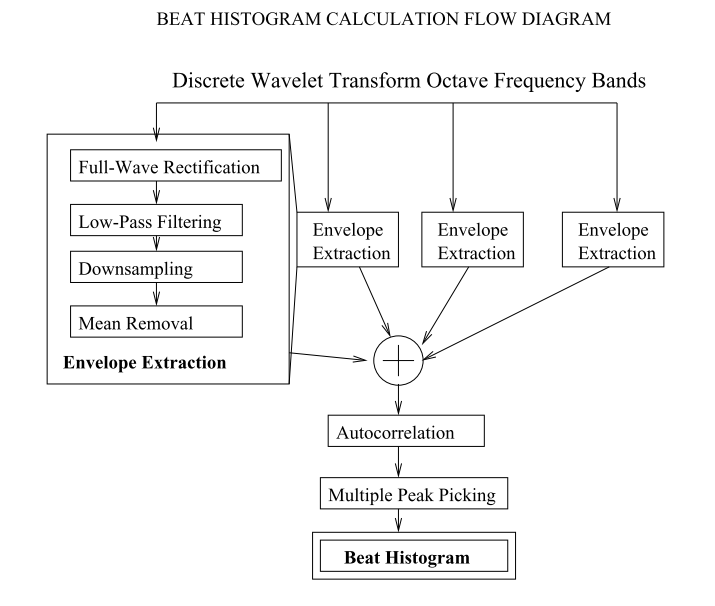

In [30]:
from IPython.core.display import Image  
Image(filename='Beat_histogram.png') 

Essentially finding "sub-tempos" in the autocorrelation function to find other significant rhythmic subdivisions, and their relationships.

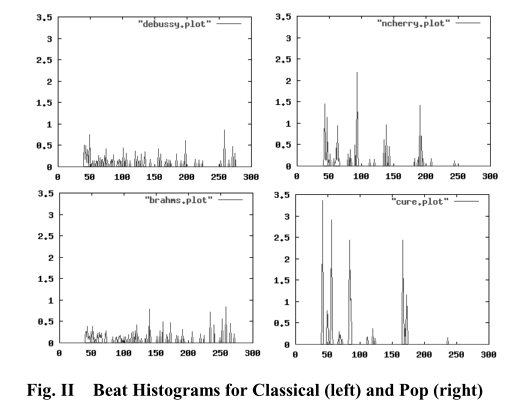

In [31]:
Image(filename='beat_hist.png') 

# Gaussian Mixture Model

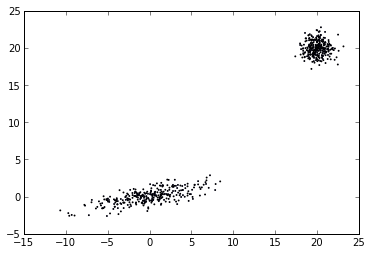

In [36]:
from sklearn import mixture
 
n_samples = 300
 
# generate random sample, two components
random.seed(0)
C = array([[0., -0.7], [3.5, .7]])
X_train = r_[np.dot(np.random.randn(n_samples, 2), C),
                np.random.randn(n_samples, 2) + np.array([20, 20])]
scatter(X_train[:, 0], X_train[:, 1], .8)

/usr/local/lib/python2.7/dist-packages/scikit_learn-0.14.1-py2.7-linux-x86_64.egg/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)


(-22.5, 32.5, -23.0, 43.0)

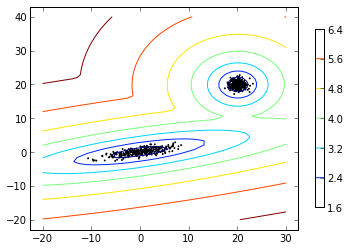

In [37]:
clf = mixture.GMM(n_components=2, covariance_type='full')
clf.fit(X_train)
 
x = linspace(-20.0, 30.0)
y = linspace(-20.0, 40.0)
X, Y = meshgrid(x, y)
XX = c_[X.ravel(), Y.ravel()]
Z = np.log(-clf.eval(XX)[0])
Z = Z.reshape(X.shape)
 
CS = contour(X, Y, Z)
CB = colorbar(CS, shrink=0.8, extend='both')
scatter(X_train[:, 0], X_train[:, 1], .8)
 
axis('tight')

In [38]:
clf.predict([(0, 10)])

array([0])

In [39]:
clf.predict([(25, 20)])

array([1])

In [40]:
clf.predict([(-20, 20)]), clf.predict([(-20, 30)])

(array([0]), array([1]))

In [43]:
points = [(-20, 20), (-20, 30), (25, 20), (0, 10)]

points0 = []
points1 = []

for p in points:
    cls = clf.predict([p])
    if cls[0] == 1:
        points1.append(p)
    else:
        points0.append(p)
print points1
print points0

[(-20, 30), (25, 20)]
[(-20, 20), (0, 10)]


/usr/local/lib/python2.7/dist-packages/scikit_learn-0.14.1-py2.7-linux-x86_64.egg/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)


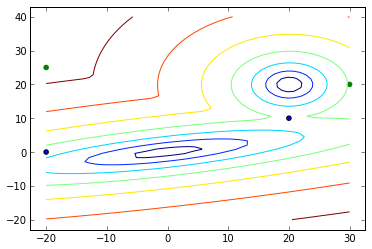

In [44]:
clf = mixture.GMM(n_components=2, covariance_type='full')
clf.fit(X_train)
 
x = linspace(-20.0, 30.0)
y = linspace(-20.0, 40.0)
X, Y = meshgrid(x, y)
XX = c_[X.ravel(), Y.ravel()]
Z = np.log(-clf.eval(XX)[0])
Z = Z.reshape(X.shape)
 
CS = contour(X, Y, Z)

scatter(*zip(points0))
scatter(*zip(points1), color='g')

axis('tight');

In [45]:
clf.predict_proba([(25, 20)])

array([[  3.15136965e-103,   1.00000000e+000]])

## Support vector machines

http://en.wikipedia.org/wiki/Support_vector_machine

In [46]:
from sklearn import svm
X = [[0, 0], [1, 1]]
y = [0, 1]
clf = svm.SVC()
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [47]:
clf.predict([[2., 2.]])

array([1])

In [48]:
clf.predict([[0., 0.1]])

array([0])

By Andrés Cabrera mantaraya36@gmail.com

For course MAT 240E at UCSB

This ipython notebook is licensed under the CC-BY-NC-SA license: http://creativecommons.org/licenses/by-nc-sa/4.0/

![http://i.creativecommons.org/l/by-nc-sa/3.0/88x31.png](http://i.creativecommons.org/l/by-nc-sa/3.0/88x31.png)